In [2]:
import os
import gzip
import _pickle as pickle

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import models, layers, activations, optimizers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_fscore_support, confusion_matrix

import itertools
import matplotlib.pyplot as plt
import skimage.transform
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")


# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


In [3]:
%run -i ../ImaGene.py

In [4]:

path = './'

In [5]:

import subprocess
subprocess.call("bash ../generate_dataset.sh params_Recent_strong.txt".split());

Let's perform the first iteration of training.
To do that, we need to read the first batch of simulations in `[..]/Binary/Simulations1`and store them into an _ImaFile_ object.

In [6]:

path_sim = './'

In [7]:
file_sim = ImaFile(simulations_folder=path_sim + 'RS/Simulations1', nr_samples=198, model_name='Marth-3epoch-CEU');

In [8]:
gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000);

In [9]:
gene_sim.summary();

An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 178, max 502, mean 314.444750, std 49.193642


In [10]:
gene_sim.filter_freq(0.01);
gene_sim.sort('rows_freq');
gene_sim.summary();
gene_sim.resize((198, 192));
gene_sim.summary();

An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 105, max 393, mean 231.834750, std 43.570316
An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


In [11]:
gene_sim.convert(flip=True);
gene_sim.summary();

An object of 4000 image(s)
Rows: min 198, max 198, mean 198.000000, std 0.000000
Columns: min 192, max 192, mean 192.000000, std 0.000000


0


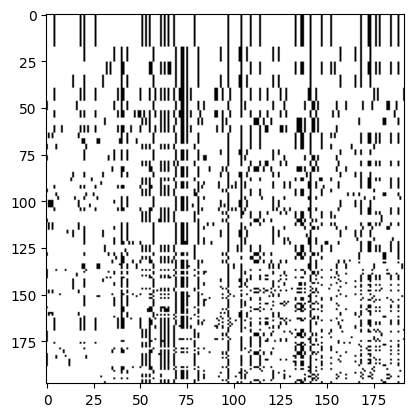

300


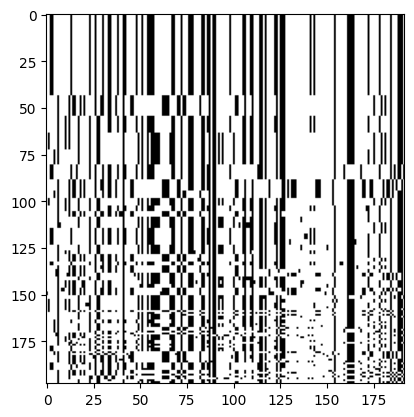

In [12]:
for sel in gene_sim.classes:
    print(sel)
    gene_sim.plot(np.where(gene_sim.targets == sel)[0][0])

In [13]:
gene_sim.subset(get_index_random(gene_sim));

In [14]:
gene_sim.targets = to_binary(gene_sim.targets);

In [15]:
model = models.Sequential([
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid', input_shape=gene_sim.data.shape[1:]),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.005, l2=0.005), padding='valid'),
                    layers.MaxPooling2D(pool_size=(2,2)),
                    layers.Flatten(),
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=1, activation='sigmoid')])

In [16]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 196, 190, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 98, 95, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 96, 93, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 46, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 44, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 23, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,145,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,173,473 (15.92 MB)

 Trainable params: 4,173,473 (15.92 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=10, verbose=1, validation_split=0.20)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9986 - loss: 0.1122 - val_accuracy: 0.9825 - val_loss: 0.1440
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9986 - loss: 0.1108 - val_accuracy: 0.9825 - val_loss: 0.1452
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9986 - loss: 0.1104 - val_accuracy: 0.9837 - val_loss: 0.1442
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9987 - loss: 0.1087 - val_accuracy: 0.9837 - val_loss: 0.1434
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9987 - loss: 0.1082 - val_accuracy: 0.9837 - val_loss: 0.1419
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9988 - loss: 0.1068 - val_accuracy: 0.9850 - val_loss: 0.1448
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9988 - loss: 0.1069 - val_accuracy: 0.9837 - val_loss: 0.1421
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9990 - loss: 0.1056 - val_accuracy: 0.9837 - v

In [25]:
net_LCT = ImaNet(name='[C32+P]x2+[C64+P]+D128')

In [26]:
net_LCT.update_scores(score);

In [27]:
i = 2
all_scores = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

i = 2
while i < 10:

    print(i)

    file_sim = ImaFile(simulations_folder=path_sim + 'RS/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
    gene_sim = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

    gene_sim.filter_freq(0.01)
    gene_sim.sort('rows_freq')
    gene_sim.resize((198, 192))
    gene_sim.convert(flip=True)

    gene_sim.subset(get_index_random(gene_sim))
    gene_sim.targets = to_binary(gene_sim.targets)

    score = model.fit(gene_sim.data, gene_sim.targets, batch_size=64, epochs=10, verbose=1, validation_split=0.20)

    # Append scores to all_scores dictionary
    all_scores['loss'].extend(score.history['loss'])
    all_scores['val_loss'].extend(score.history['val_loss'])
    all_scores['accuracy'].extend(score.history['accuracy'])
    all_scores['val_accuracy'].extend(score.history['val_accuracy'])

    i += 1

2
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9915 - loss: 0.1295 - val_accuracy: 0.9937 - val_loss: 0.1155
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9931 - loss: 0.1258 - val_accuracy: 0.9937 - val_loss: 0.1154
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9935 - loss: 0.1242 - val_accuracy: 0.9937 - val_loss: 0.1151
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9939 - loss: 0.1227 - val_accuracy: 0.9937 - val_loss: 0.1150
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9945 - loss: 0.1214 - val_accuracy: 0.9937 - val_loss: 0.1149
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9942 - loss: 0.1213 - val_accuracy: 0.9937 - val_loss: 0.1148
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9953 - loss: 0.1194 - val_accuracy: 0.9937 - val_loss: 0.1147
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9956 - loss: 0.1194 - val_accuracy: 0.9937 -

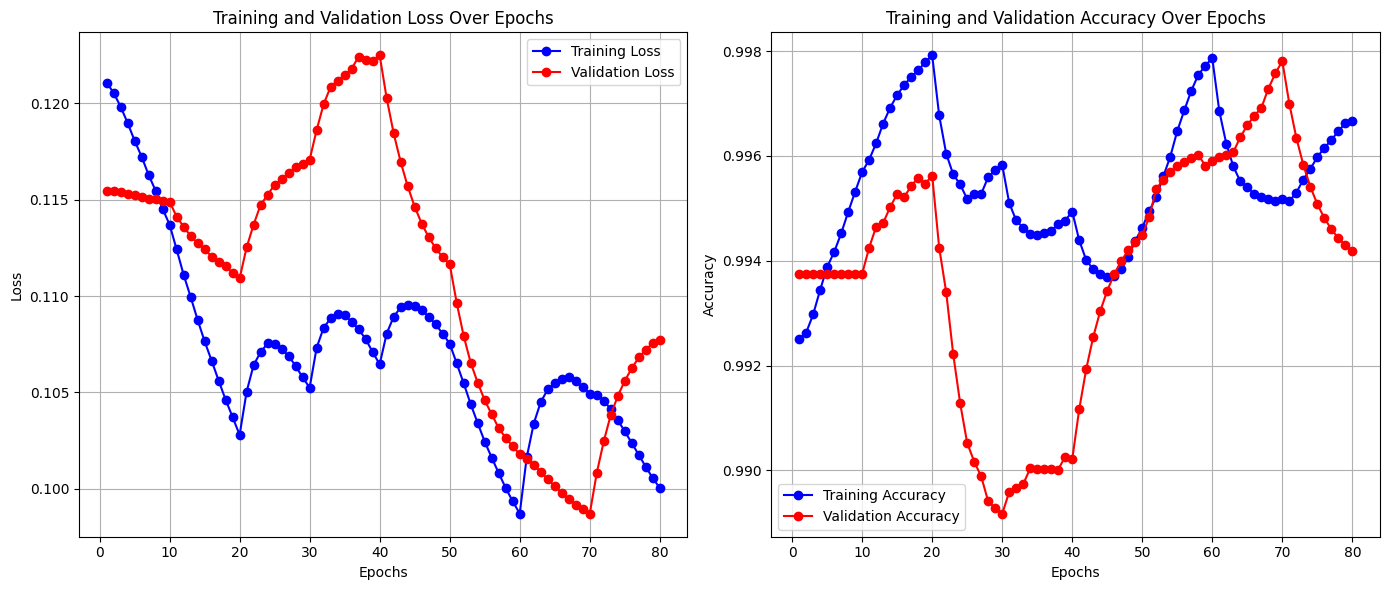

In [28]:
# Define the number of epochs for plotting
epochs = range(1, len(all_scores['loss']) + 1)

# Function to smooth the data for better visualization (optional)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Create a figure for plotting with better visualization settings
plt.figure(figsize=(14, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, smooth_curve(all_scores['loss']), 'bo-', label='Training Loss')
plt.plot(epochs, smooth_curve(all_scores['val_loss']), 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, smooth_curve(all_scores['accuracy']), 'bo-', label='Training Accuracy')
plt.plot(epochs, smooth_curve(all_scores['val_accuracy']), 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

Evaluate the training on the testing dataset, i.e. the last batch of simulated data.

In [30]:
i = 10
file_sim = ImaFile(simulations_folder=path_sim + 'RS/Simulations' + str(i), nr_samples=198, model_name='Marth-3epoch-CEU')
gene_sim_test = file_sim.read_simulations(parameter_name='selection_coeff_hetero', max_nrepl=4000)

gene_sim_test.filter_freq(0.01)
gene_sim_test.sort('rows_freq')
gene_sim_test.resize((198, 192))
gene_sim_test.convert(flip=True)

rnd_idx = get_index_random(gene_sim_test) # no need to create this extra variable
gene_sim_test.subset(rnd_idx)

gene_sim_test.targets = to_binary(gene_sim_test.targets);

In [31]:
net_LCT.test = model.evaluate(gene_sim_test.data, gene_sim_test.targets, batch_size=None, verbose=0)
print(net_LCT.test) # it will report [loss, accuracy]

[0.09906666725873947, 0.996999979019165]


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


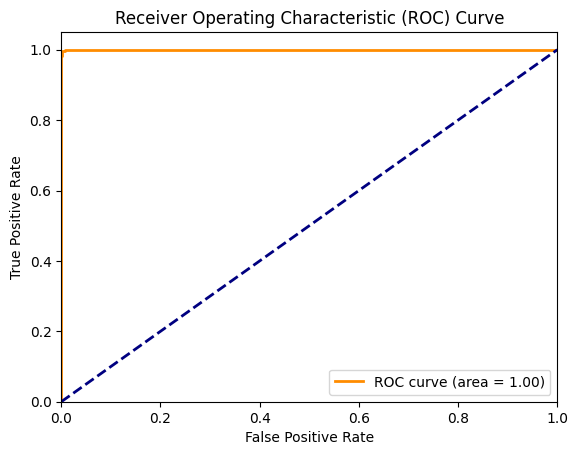

F1 Score: 0.9969984992496247
Precision: 0.9974974974974975
Recall (Sensitivity): 0.9965


In [32]:
# Make predictions on the validation data
predictions = model.predict(gene_sim_test.data)

# Calculate F1 score
f1 = f1_score(gene_sim_test.targets, predictions.round())

# Calculate precision, recall, and F-score
precision, recall, fscore, _ = precision_recall_fscore_support(gene_sim_test.targets, predictions.round(), average='binary')

# Recall is equivalent to sensitivity
sensitivity = recall

# Compute ROC curve and AUC (Area Under the Curve)
fpr, tpr, _ = roc_curve(gene_sim_test.targets, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print additional metrics
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall (Sensitivity): {sensitivity}')

Plot the confusion matrix after predicting the responses from the testing data.

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


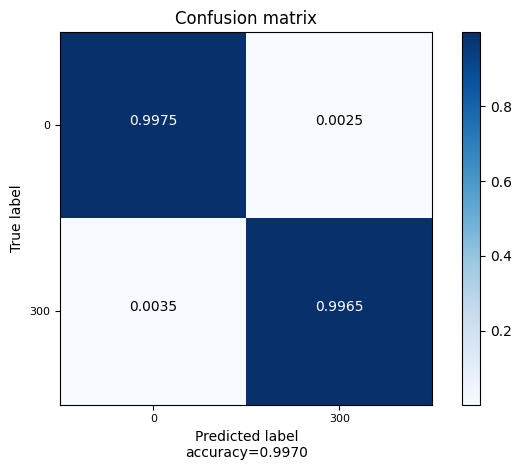

0

In [33]:
net_LCT.predict(gene_sim_test, model)
net_LCT.plot_cm(gene_sim_test.classes, text=True)

In [34]:
path = './'
filename = 'RS_Basline.keras'

# Save the trained model to a file using the recommended Keras format
model.save(path + filename)
#Model saved to Google Drive
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path and filename
path = '/content/drive/My Drive/models/'
filename = 'RS_Baseline.keras'

# Save the trained model to the specified path
model.save(path + filename)


Mounted at /content/drive
